##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# tf.keras를 사용한 Neural Style Transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />TensorFlow.org에서 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />깃허브(GitHub) 소스 보기</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: 이 문서는 텐서플로 커뮤니티에서 번역했습니다. 커뮤니티 번역 활동의 특성상 정확한 번역과 최신 내용을 반영하기 위해 노력함에도
불구하고 [공식 영문 문서](https://www.tensorflow.org/?hl=en)의 내용과 일치하지 않을 수 있습니다.
이 번역에 개선할 부분이 있다면
[tensorflow/docs-l10n](https://github.com/tensorflow/docs-l10n/) 깃헙 저장소로 풀 리퀘스트를 보내주시기 바랍니다.
문서 번역이나 리뷰에 참여하려면
[docs-ko@tensorflow.org](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ko)로
메일을 보내주시기 바랍니다.

## 개요

이번 튜토리얼에서는 딥러닝을 사용하여 원하는 이미지를 다른 스타일의 이미지로 구성하는 법을 배워보겠습니다(피카소나 반 고흐처럼 그리기를 희망하나요?). 이 기법은 *Neural Style Transfer*로 알려져있으며, Leon A. Gatys의 논문 [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)에 잘 기술되어 있습니다.

참고: 본 튜토리얼은 처음에 발표된 기존의 스타일 전이 알고리즘을 소개합니다. 이 알고리즘은 이미지의 콘텐츠를 특정 스타일에 최적화시키는 방식으로 작동합니다. 보다 최근에 개발된 ([CycleGan](cyclegan.ipynb)과 같은) 알고리즘은 모델로 하여금 스타일이 변이된 이미지를 직접 생성하도록 만듭니다. 이 접근은 기존의 스타일 전이 알고리즘에 비해 훨씬 빠릅니다 (최대 1000배). [텐서플로 허브](https://tensorflow.org/hub)와 [텐서플로 라이트](https://www.tensorflow.org/lite/models/style_transfer/overview)에서는 이러한 [사전 훈련된 이미지 변이 모듈](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_arbitrary_image_stylization.ipynb)을 제공하고 있습니다.

Neural style transfer은 *콘텐츠 (content)* 이미지와 (유명한 작가의 삽화와 같은) *스타일 참조 (style reference)* 이미지를 이용하여, 콘텐츠 이미지의 콘텐츠는 유지하되  스타일 참조 이미지의 화풍으로 채색한 것 같은 새로운 이미지를 생성하는 최적화 기술입니다.

이 과정은 출력 이미지를 콘텐츠 이미지의 콘텐츠 통계랑(statistic)과 스타일 참조 이미지의 스타일 통계량에 맞춰 최적화시킴으로써 구현됩니다. 통계량은 합성곱 신경망을 이용해 각각의 이미지에서 추출합니다.

예시로, 아래에 주어진 강아지의 이미지와 바실리 칸딘스키의 7번 작품을 살펴봅시다:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[노란 래브라도](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), 출처: 위키미디아 공용

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


만약 칸딘스키가 7번 작품의 화풍으로 이 강아지를 그렸다면 어떤 작품이 탄생했을까요? 아마 이런 그림이 아니었을까요?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## 설정

### 모듈 구성 및 임포트

In [26]:
import tensorflow as tf

In [27]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [28]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

이미지를 다운로드받고 스타일 참조 이미지와 콘텐츠 이미지를 선택합니다:

In [29]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [30]:
print(content_path)
print(style_path)

content_path = 'chun.jpg'
style_path = 'mone.jpg'

/root/.keras/datasets/YellowLabradorLooking_new.jpg
/root/.keras/datasets/kandinsky5.jpg


## 입력 시각화

이미지를 불러오는 함수를 정의하고, 최대 이미지 크기를 512개의 픽셀로 제한합니다.

In [31]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

이미지를 출력하기 위한 간단한 함수를 정의합니다:

In [32]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

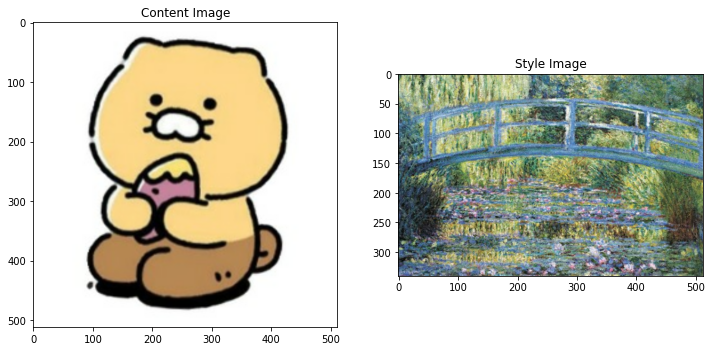

In [33]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## TF-Hub를 통한 빠른 스타일 전이

앞서 언급했듯이, 본 튜토리얼은 이미지 콘텐츠를 특정 스타일에 맞춰 최적화시키는 기존의 스타일 전이 알고리즘을 소개합니다. 이에 대해 살펴보기 전에, [텐서플로 허브](https://tensorflow.org/hub) 모듈은 어떤 결과물을 생성하는지 시험해봅시다:

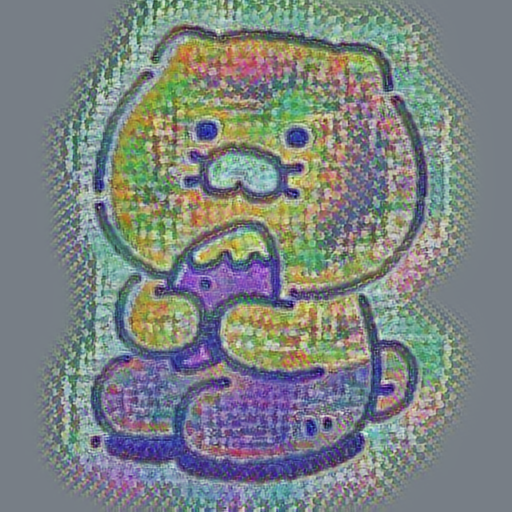

In [34]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)